# **Analysis for Light/Dark protocol**

## This analysis script is well suited to analyse the data from the light/dark protocol: 20min initial baseline light + multiple times off/on + final light baseline.

load modules

In [1]:
%load_ext autoreload

%autoreload 2
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
%matplotlib inline
from spikeA.Session import *
from spikeA.Spike_train_loader import Spike_train_loader
from spikeA.Cell_group import Cell_group
from spikeA.Animal_pose import Animal_pose
from spikeA.Session import Session
from spikeA.Intervals import Intervals
from spikeA.ttl import detectTTL

set session name

In [2]:
# name="pk3864-10022022-0101"
# name="pk3864-11022022-0101"
# name="pk3864-16022022-0101"
# name="pk3864-21022022-0101"
# name="pk3864-23022022-0101"
# name="pk3864-24022022-0101"
# name="pk3864-25022022-0101"
# name="pk3864-28022022-0101"
# name="pk3864-01032022-0103"
# name="pk3864-03032022-0103"
# name="pk3864-08032022-0103"
# name="pk3864-09032022-0101"
# name="pk3864-10032022-0101"
# name="bt64245-14032022-0101" # only MEC implanted (64ch Cambridge), investigate grid cells rotation
# name="bt64245-15032022-0101"
# name="pk3864-17032022-0101"

name="pk3190-31052022-0102"
name="pk3190-01062022-0103"
#name="pk3190-03062022-0102"
name="pk3190-06062022-0102"
#name="pk3190-07062022-0103"

Check the path

In [3]:
import os

basedir = "/adata/electro"
subject, session = name.split("-",1)
path = basedir+"/"+subject+"/"+name+"/"

fname = name.split("_")[0]

print("Path:", path)
print("Mouse:", subject) # directory = mouse subject name
print("Session:", session)
print("Name:", name, ",", fname)
print("")
print("Path:", "OK" if os.path.isdir(path) else "invalid")

Path: /adata/electro/pk3190/pk3190-06062022-0102/
Mouse: pk3190
Session: 06062022-0102
Name: pk3190-06062022-0102 , pk3190-06062022-0102

Path: OK


## Get a Session object

Check the files

In [4]:
ses = Kilosort_session(name=fname, path=path)
ses.load_parameters_from_files(ignore_params=True)  # ignore_params if kilosort has not been executed so far
print(ses)

<class 'spikeA.Session.Kilosort_session'>
name = pk3190-06062022-0102
path = /adata/electro/pk3190/pk3190-06062022-0102
subject = pk3190
session_dat_time = 2022-06-06 01:02:00
fileBase = /adata/electro/pk3190/pk3190-06062022-0102/pk3190-06062022-0102
file_names = {'par': '/adata/electro/pk3190/pk3190-06062022-0102/pk3190-06062022-0102.par', 'desen': '/adata/electro/pk3190/pk3190-06062022-0102/pk3190-06062022-0102.desen', 'desel': '/adata/electro/pk3190/pk3190-06062022-0102/pk3190-06062022-0102.desel', 'sampling_rate': '/adata/electro/pk3190/pk3190-06062022-0102/pk3190-06062022-0102.sampling_rate_dat', 'stimulation': '/adata/electro/pk3190/pk3190-06062022-0102/pk3190-06062022-0102.stimulation', 'px_per_cm': '/adata/electro/pk3190/pk3190-06062022-0102/pk3190-06062022-0102.px_per_cm', 'setup': '/adata/electro/pk3190/pk3190-06062022-0102/pk3190-06062022-0102.setup', 'environmentFamiliarity': '/adata/electro/pk3190/pk3190-06062022-0102/pk3190-06062022-0102.environmentFamiliarity', 'params':

In [5]:
ses.trial_intervals.inter

array([[   0.     , 6540.03595],
       [6540.036  , 7518.29995]])

## Load spikes

In [6]:
stl = Spike_train_loader()
stl.load_spike_train_kilosort(ses)
print("stl.clu_ids",stl.clu_ids)
cg = Cell_group(stl)

stl.clu_ids [  3   4   6   7   8  10  11  12  13  14  16  17  19  22  23  25  26  29
  30  31  33  36  37  39  55  56  76  77  78  79  80  81  82  84  85  86
  87  88  89  90  92  96  97 102 103 107 119 121 122 123]


## Load the waveforms

Set the waveform and channel information from the session template file.

In [7]:
cg.set_info_from_session(ses, maxchannels=5)

Templates: 122 , timepoints: 82 , Channels: 64
Loaded templates-clusters-map, spikes: 3536339 , clusters: 120
Init shanks: 8


For each cluster, print the active channels where the spikes were detected, and the corresponding brain area.

In [8]:
unique, counts = np.unique([ '/'.join(n.brain_area) for n in cg.neuron_list ] , return_counts=True )

for u,c in zip(unique, counts):
    print(u,":",c)

adn : 24
mec : 26


## Create a pose file 

In [9]:
ap = Animal_pose(ses)
posefilename = ses.fileBase + ap.pose_file_extension
print("look for", posefilename)
if not os.path.exists(posefilename):
    print("load from positrack")
    extension = ap.positrack_type()
    print("use extension:",extension)
    ap.pose_from_positrack_files(ses=ses, interpolation_frequency_hz = 50, extension=extension)
    ap.save_pose_to_file() # save the file for next time
else:
    print("load from saved pose file")
    ap.load_pose_from_file()

look for /adata/electro/pk3190/pk3190-06062022-0102/pk3190-06062022-0102.pose.npy
load from saved pose file


In [10]:
ap.invalid_ratio()

0.22250449568520628

In [11]:
# find good shape automagically & crop
diameter=90.
xy_range=ap.find_xy_range(diameter=diameter)  ###-> do this within intervals , for each trial + use min/max to find best square that covers most of the area
xyrange_min,xyrange_max = xy_range
xyrange_mean = np.mean(xy_range, axis=0) # = center
xmean,ymean = ap.meanloc
print("xmean,ymean",xmean,ymean)
print("xyrange_min,xyrange_max",xyrange_min,xyrange_max)
print("xyrange_mean",xyrange_mean)

xmean,ymean 47.53878181995972 85.67137444802975
xyrange_min,xyrange_max [ 2.53878182 49.        ] [ 92.53878182 139.        ]
xyrange_mean [47.53878182 94.        ]


Plot the path of the animal to see if it was loaded correctly.

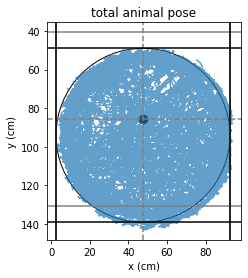

In [12]:
plt.plot(ap.pose[:,1],ap.pose[:,2], alpha=.7)
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.scatter([xmean],[ymean], color="black", s=75)
plt.axvline(x=xmean, color="gray", ls='dashed')
plt.axhline(y=ymean, color="gray", ls='dashed')
plt.axvline(x=xmean+diameter/2, color="gray")
plt.axhline(y=ymean+diameter/2, color="gray")
plt.axvline(x=xmean-diameter/2, color="gray")
plt.axhline(y=ymean-diameter/2, color="gray")

plt.axvline(x=xyrange_min[0], color="black")
plt.axvline(x=xyrange_max[0], color="black")
plt.axhline(y=xyrange_min[1], color="black")
plt.axhline(y=xyrange_max[1], color="black")

circarena_center = tuple(xyrange_mean)
circarena_radius= diameter/2
circle1 = patches.Circle(circarena_center, circarena_radius, color='black', fill=None)
plt.gca().add_patch(circle1)


plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("total animal pose")
plt.show()

In [13]:
# diameter_ = 80.
diameter_ = diameter
xy_range_ = ap.invalid_outside_spatial_area(shape="circle", radius=diameter_/2., center=xyrange_mean)
print("xy_range_", xy_range_)

xy_range_ [[  2.53878182  49.        ]
 [ 92.53878182 139.        ]]


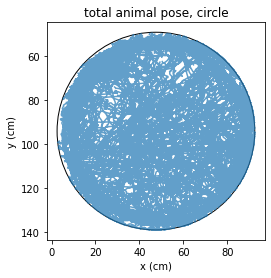

In [14]:
plt.plot(ap.pose[:,1],ap.pose[:,2], alpha=.7)
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")

circle1 = patches.Circle(circarena_center, circarena_radius, color='black', fill=None)
plt.gca().add_patch(circle1)

plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("total animal pose, circle")
plt.show()

Plot the occupancy map to see where the animal spent more or less time.

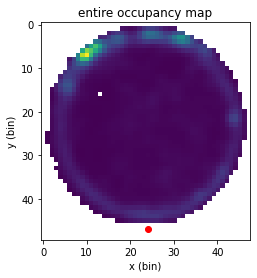

In [15]:
ap.occupancy_map_2d(smoothing=True)
plt.imshow(ap.occupancy_map.T)
plt.scatter([24],[47],color='red')
plt.xlabel("x (bin)")
plt.ylabel("y (bin)")
plt.title("entire occupancy map")
plt.show()

In [16]:
ap.coord_cm2bin(49,138)

(24, 45)

## Light/Dark Intervals

In [17]:
times = []

In [18]:
# if there are times in the dat file, use them even if we have times in the session

if ses.n_channels == 66:
    ## get times from dat file channel
    print("get times from dat file channel")
    times_filename = ses.fileBase + ".times.npy"
    print("look for", times_filename)
    if os.path.exists(times_filename):
        print("load from saved file")
        times = np.load(times_filename)
    else:
        print("generate from dat files")
        df = Dat_file_reader(file_names = ses.dat_file_names, n_channels = ses.n_channels)
        light_channel_data = df.get_data_one_block(0,df.files_last_sample[-1],np.array([ses.n_channels-2]))
        print("light_channel_data", light_channel_data.shape)
        ups,downs = detectTTL(ttl_data = light_channel_data)
        print("ups:",len(ups),", downs:",len(downs))
        # plt.scatter(ups,np.ones(len(ups)))
        # plt.scatter(downs,np.zeros(len(downs)))
        times = np.sort(np.concatenate((ups/ses.sampling_rate, downs/ses.sampling_rate, np.array([0, ses.trial_intervals.inter[-1,1]]))))
        # correct for errornous switching at the beginning
        times = times[np.logical_or(times>1000,times==0)]
        # save for later loading
        np.save(times_filename, times)
        print("saved")

In [19]:
if not len(times):
    ## get times from external time source
    print("get times from external time source")
    times = ses.log_times
    print(times.shape)
    print(times)

get times from external time source
(42,)
[   0.         1427.45708126 1555.17291974 1679.37346014 1803.86284968
 1927.64399028 2052.21441092 2178.15206804 2303.27413576 2428.3981395
 2552.04398128 2675.71401227 2799.36852608 2923.0318305  3046.68936286
 3170.36524213 3293.9275492  3417.62156248 3541.21948018 3664.89287998
 3788.49249533 3912.15571959 4035.73981152 4159.79572184 4283.40829714
 4407.08618497 4530.73139733 4654.41199857 4778.03960551 4901.71322022
 5025.26998855 5148.95678976 5273.11847926 5396.78531582 5520.42142568
 5644.09258599 5767.73350964 5891.41223372 6015.02656522 6138.73894341
 6262.36287377 7518.29995   ]


In [20]:
if not len(times):
    ## artificially create light switches (just for testing, not recommended, rather use clock sync)
    print("artificially create light switches")
    ## light_switches = times of light switched (on/off), starts with off, at 0s switched on
    light_switches = [0.]
    for i in range(2*20):
        p = 1200.+120.*i
        light_switches.append(p)
    light_switches.append(p+1200)

    # for i,l in enumerate(light_switches):
    #    print("#",i," : ",l," (",(i+1)%2,")")

    # light_dark_intervals = ap.times2intervals(light_switches)
    # print(light_dark_intervals)
    times = light_switches

In [21]:
if not len(times):
    raise ValueError("no times")

In [22]:
print("times:",len(times))
print(times)

times: 42
[   0.         1427.45708126 1555.17291974 1679.37346014 1803.86284968
 1927.64399028 2052.21441092 2178.15206804 2303.27413576 2428.3981395
 2552.04398128 2675.71401227 2799.36852608 2923.0318305  3046.68936286
 3170.36524213 3293.9275492  3417.62156248 3541.21948018 3664.89287998
 3788.49249533 3912.15571959 4035.73981152 4159.79572184 4283.40829714
 4407.08618497 4530.73139733 4654.41199857 4778.03960551 4901.71322022
 5025.26998855 5148.95678976 5273.11847926 5396.78531582 5520.42142568
 5644.09258599 5767.73350964 5891.41223372 6015.02656522 6138.73894341
 6262.36287377 7518.29995   ]


In [23]:
# np.diff(times)
# times[0]=0
# times[-1] = ses.trial_intervals.inter[-1,1]
# times=np.append(times,[ses.trial_intervals.inter[-1,1]])
# np.save(path+'times.npy',times)

In [24]:
# create intervals from logged times
light_dark_intervals = ap.times2intervals(times)
print("Intervals:", light_dark_intervals.shape)
print("first: ",light_dark_intervals[0])
print("last: ",light_dark_intervals[-1])

Intervals: (41, 2)
first:  [   0.         1427.45708126]
last:  [6262.36287377 7518.29995   ]


In [25]:
for i,intv in enumerate(light_dark_intervals):
    print("#",i,":",intv,"-",np.diff(intv)[0],"sec","-","dark" if i%2 else "light","")

# 0 : [   0.         1427.45708126] - 1427.4570812634838 sec - light 
# 1 : [1427.45708126 1555.17291974] - 127.71583847848706 sec - dark 
# 2 : [1555.17291974 1679.37346014] - 124.20054039751244 sec - light 
# 3 : [1679.37346014 1803.86284968] - 124.48938953565153 sec - dark 
# 4 : [1803.86284968 1927.64399028] - 123.78114060758548 sec - light 
# 5 : [1927.64399028 2052.21441092] - 124.57042063758149 sec - dark 
# 6 : [2052.21441092 2178.15206804] - 125.9376571192538 sec - light 
# 7 : [2178.15206804 2303.27413576] - 125.12206771619958 sec - dark 
# 8 : [2303.27413576 2428.3981395 ] - 125.12400374859317 sec - light 
# 9 : [2428.3981395  2552.04398128] - 123.64584177547886 sec - dark 
# 10 : [2552.04398128 2675.71401227] - 123.67003099303656 sec - light 
# 11 : [2675.71401227 2799.36852608] - 123.65451380688091 sec - dark 
# 12 : [2799.36852608 2923.0318305 ] - 123.66330441605805 sec - light 
# 13 : [2923.0318305  3046.68936286] - 123.6575323592524 sec - dark 
# 14 : [3046.68936286 317

In [26]:
# select the initial baseline
baseline_interval = light_dark_intervals[0]
print("baseline_interval",baseline_interval)

baseline_interval [   0.         1427.45708126]


In [27]:
# select the final baseline
baseline_interval_2 = light_dark_intervals[-1]
print("baseline_interval_2",baseline_interval_2)

baseline_interval_2 [6262.36287377 7518.29995   ]


In [28]:
# select the light/dark intervals

light_dark_intervals_without_baseline = light_dark_intervals[1:-1] # remove first and last interval (baselines)
#light_dark_intervals_without_baseline = light_dark_intervals[1:] # remove first baseline

dark_intervals = light_dark_intervals_without_baseline[::2] # every second interval is dark, starting from the first one
print("dark intervals (",len(dark_intervals),")")
print(dark_intervals)

print("")

light_intervals = light_dark_intervals_without_baseline[1::2] # every second interval is dark, starting from the second one
print("light intervals (",len(light_intervals),")")
print(light_intervals)

dark intervals ( 20 )
[[1427.45708126 1555.17291974]
 [1679.37346014 1803.86284968]
 [1927.64399028 2052.21441092]
 [2178.15206804 2303.27413576]
 [2428.3981395  2552.04398128]
 [2675.71401227 2799.36852608]
 [2923.0318305  3046.68936286]
 [3170.36524213 3293.9275492 ]
 [3417.62156248 3541.21948018]
 [3664.89287998 3788.49249533]
 [3912.15571959 4035.73981152]
 [4159.79572184 4283.40829714]
 [4407.08618497 4530.73139733]
 [4654.41199857 4778.03960551]
 [4901.71322022 5025.26998855]
 [5148.95678976 5273.11847926]
 [5396.78531582 5520.42142568]
 [5644.09258599 5767.73350964]
 [5891.41223372 6015.02656522]
 [6138.73894341 6262.36287377]]

light intervals ( 19 )
[[1555.17291974 1679.37346014]
 [1803.86284968 1927.64399028]
 [2052.21441092 2178.15206804]
 [2303.27413576 2428.3981395 ]
 [2552.04398128 2675.71401227]
 [2799.36852608 2923.0318305 ]
 [3046.68936286 3170.36524213]
 [3293.9275492  3417.62156248]
 [3541.21948018 3664.89287998]
 [3788.49249533 3912.15571959]
 [4035.73981152 4159.79

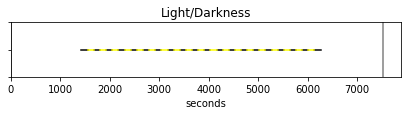

In [29]:
# visualize the light/dark intervals

plt.figure(figsize=(7,1))

plt.axvline(x=np.min(light_dark_intervals), color='grey')
plt.axvline(x=np.max(light_dark_intervals), color='grey')

plt.xlim((0,np.max(light_dark_intervals)*1.05))
plt.ylim((-0.5,0.5))
plt.gca().set(yticklabels=[])  

for dark_interval in dark_intervals:
    plt.plot(dark_interval, [0,0], color='black')
for light_interval in light_intervals:
    plt.plot(light_interval, [0,0], color='yellow')

plt.xlabel("seconds")

plt.title("Light/Darkness")

plt.show()


### **Initial Baseline**

Use the initial baseline (20min) to detect HD cells

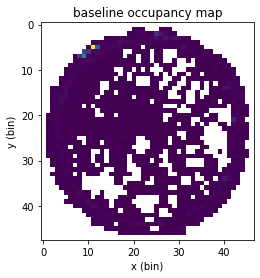

In [38]:
ap.set_intervals(baseline_interval)
#ap.occupancy_map_2d(smoothing=True) # False
ap.occupancy_map_2d(smoothing=False)
plt.imshow(ap.occupancy_map.T)
plt.xlabel("x (bin)")
plt.ylabel("y (bin)")
plt.title("baseline occupancy map")
plt.show()

In [35]:
ap.invalid_ratio()

0.19627870483235957

In [36]:
occupancy = ap.occupancy(arena='circle')
print("occupancy: {:.1f} %".format(occupancy*100))

occupancy: 76.4 %


#### for each cell

interval used = [ 223.71372535 1427.45708126]


KeyboardInterrupt: 

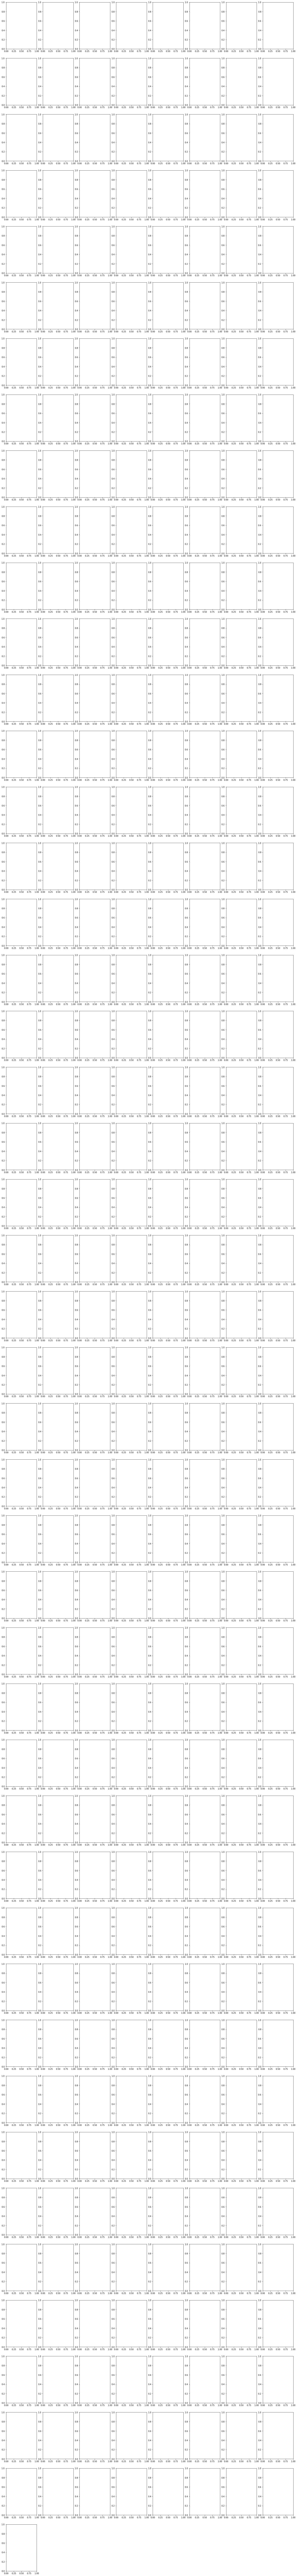

In [33]:
# make the analysis for the baseline only
iv=np.array(baseline_interval)
#iv=np.array(baseline_interval_2) # final baseline (test)
print("interval used =",iv)

hd_firing_list=[] # neurons tuning curve
hd_ifr_list=[] # ifr list
spike_trains = [] # spike trains
hd_neurons = [] ## list of ids of HD neurons
gc_neurons = [] ## list of ids of GC neurons

cg.set_spatial_properties(ap)

# from matplotlib.patches import Rectangle

cols = 8

fig, axs = plt.subplots(len(cg.neuron_list), cols, figsize=(25, 5*len(cg.neuron_list)))
   
for i, n in enumerate(cg.neuron_list):

    # reset and set intervals
    n.spike_train.unset_intervals()
    ap.unset_intervals()
    n.spike_train.set_intervals(iv)
    ap.set_intervals(iv)
    
    print("i",i,"/","n",n.name)
    # print("n",n.spike_train.intervals.total_interval_duration_seconds())
    # print("ap",ap.intervals.total_interval_duration_seconds())
    
    
    # temporal auto-correlation
      
    n.spike_train.spike_time_autocorrelation(bin_size_sec=0.0005,min_sec=-0.05, max_sec=0.05)
    timestamp = n.spike_train.mid_point_from_edges(n.spike_train.st_autocorrelation_histogram[1])
    axs[i,0].plot(timestamp, n.spike_train.st_autocorrelation_histogram[0])
    
    n.spike_train.spike_time_autocorrelation(bin_size_sec=0.0025,min_sec=-0.5, max_sec=0.5)
    timestamp = n.spike_train.mid_point_from_edges(n.spike_train.st_autocorrelation_histogram[1])
    axs[i,1].plot(timestamp, n.spike_train.st_autocorrelation_histogram[0])
    
    
    # spatial firing map 
    
    n.set_spatial_properties(ap)
    n.spatial_properties.firing_rate_map_2d(cm_per_bin =2, smoothing_sigma_cm = 2, smoothing=True, xy_range=xy_range)
    im = axs[i,2].imshow(n.spatial_properties.firing_rate_map.T,cmap='jet')
    axs[i,2].set_title("clu:{}, mRate:{:.3} Hz".format(n.name,n.spike_train.mean_firing_rate()))
    fig.colorbar(im,ax=axs[i,2])
    
    
    
    # Spatial autocorrelation Map & Grid Score
    gs = n.spatial_properties.grid_score()
    # print("grid score:",gs)
    is_grid_cell = (gs > .4)
    fw = "bold" if is_grid_cell else "normal"
    if is_grid_cell:
        gc_neurons.append(i)
        print("GC neuron",i)

    
    axs[i,3].imshow(n.spatial_properties.spatial_autocorrelation_map)
    axs[i,3].set_title("spatial autocorrelation"+"\n"+"Grid Score: "+str(round(gs,2)), fontweight=fw)
    
    # Head direction
    # ap.invalid_outside_head_direction_range()
    n.spatial_properties.firing_rate_head_direction_histogram(smoothing=False)
    
    angles = n.spatial_properties.mid_point_from_edges(n.spatial_properties.firing_rate_head_direction_histo_edges)
    hd_firing = n.spatial_properties.firing_rate_head_direction_histo
    hd_mean_direction_rad, hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate = n.spatial_properties.head_direction_score()
    
    axs[i,4].plot(angles, hd_firing)
    axs[i,4].set_xlabel("Head direction")
    axs[i,4].set_ylabel("Firing rate (Hz)")
    axs[i,4].set_ylim(0, np.nanmax(n.spatial_properties.firing_rate_head_direction_histo)*1.2+0.1)
    axs[i,4].axvline(x=hd_mean_direction_rad, color="black")
    #axs[i,4].text(s=str(round(hd_mean_direction_rad*180./np.pi))+" ° (vector length = "+str(hd_mean_vector_length)+")",x=hd_mean+.1,y=1)
    
    fw = "bold" if (hd_mean_vector_length>.4 and hd_peak_rate>3) else "normal"
    axs[i,5].axis('off')
    ax2 = fig.add_subplot(len(cg.neuron_list), cols, cols*i+6, polar=True)
    #ax2.plot(angles, hd_firing)
    ax2.plot(np.append(angles,angles[0]), np.append(hd_firing,hd_firing[0]))
    ax2.plot([hd_mean_direction_rad]*2, [0,max(hd_firing)] , color="blue", alpha=hd_mean_vector_length if np.isfinite(hd_mean_vector_length) else 0., lw=2.5  )
    if np.isfinite(hd_mean_direction_deg) and np.isfinite(hd_mean_vector_length):
        ax2.set_title("Head direction" + "\n" + "mean direction: " + str(round( (hd_mean_direction_deg + 360) % 360  )) +"°" + "\n" + "mean vector length: " + str(np.round(hd_mean_vector_length,2))  , fontweight=fw) 
    else:
        ax2.set_title("Head direction: no data")
    ax2.grid(True)
    
    
    # Waveforms
    
    cluster = int(n.name) # current cluster name
    channels = ses.get_channels_from_cluster(cluster) # get channels with highest amplitude
    
    if (len(channels)):
    
        for j,channel in enumerate(channels):
            channel_mapped, waveform = ses.get_waveform_from_cluster(cluster, channel)
            axs[i,6].axhline( y = -j*.5 , color="grey" , lw=.5 )
            #label = "channel: "+str(channel)+" ("+str(channel_mapped)+")"
            label = "channel "+str(channel_mapped)
            axs[i,6].plot( waveform -j*.5 , label=label , color="blue")
            axs[i,6].text( s= label , x=0, y=-j*.5 +.1 )
        axs[i,6].set_xlabel("time sample")
        axs[i,6].set(yticklabels=[])  
        axs[i,6].set_title("Waveform of Cluster "+str(cluster))
        
    # channels / shanks / brain region
    shanks_arr, active_shanks, electrodes = ses.get_active_shanks(channels)
    brain_region = '/'.join(electrodes)
   
    for j, (shank, active) in enumerate(zip(ses.shanks_all, shanks_arr)):
        color = 'blue' if active else 'gray'
        circle = plt.Circle((j,0), 0.2, color=color)
        axs[i,7].add_patch(circle)

    
    axs[i,7].axis('off')
    axs[i,7].set_title("Active Shanks for cluster "+str(cluster)+"\n"+', '.join([str(int(active_shank)) for active_shank in active_shanks]) + " ("+brain_region+")")
    
    axs[i,7].set_xlim([-1, len(ses.shanks_all)])
    axs[i,7].set_ylim([-0.5, 0.5])
    
    ###########################
    # classify, find category: Grid cell, HD cell
    
    is_hd_cell = (hd_mean_vector_length>.35 and hd_peak_rate>3 and brain_region=="adn")
    if (is_hd_cell):
        n.spike_train.instantaneous_firing_rate(bin_size_sec=2.e-2)
        # print("n.name",n.name)
        # print("n.spike_train.ifr",n.spike_train.ifr)
        # print("n.spike_train.st",n.spike_train.st)
        
        hd_firing_list.append(hd_firing)
        hd_ifr_list.append(n.spike_train.ifr)
        spike_trains.append(n.spike_train.st)
        
        hd_neurons.append(i)
        print("HD neuron",i)
        
        #rect = Rectangle((0.08, 1-(i+.5)/len(cg.neuron_list)), 0.85, 1/len(cg.neuron_list), facecolor='yellow', edgecolor='none', transform=fig.transFigure, zorder=-1)
        #fig.patches.append(rect)

    
plt.suptitle("Cell overview ({}) - Baseline ({:.1f} s)".format(name, n.spike_train.intervals.total_interval_duration_seconds()), fontsize=16, fontweight='bold')
#plt.tight_layout()
#fig.subplots_adjust(wspace=0.33, hspace=.5)
fig.subplots_adjust(wspace=0.33, hspace=.5, top=0.95) # top=0.975
# plt.savefig('/home/pascal/Documents/science_docs/analysis_results/'+name+'_baseline2.pdf')
plt.show()


In [ ]:
hd_neurons

In [ ]:
gc_neurons

### HD decoding

In [ ]:
# manually define HD neurons
neuron_names=[32,36,37,38,39,40] # 34,38,46,48,49,50
hd_neurons_man = np.array([i for i,n in enumerate(cg.neuron_list) if int(n.name) in neuron_names ])
hd_neurons_man

In [ ]:
spike_trains = []

for i,n in enumerate(cg.neuron_list):
    if i in hd_neurons:#_man:# or use hd_neurons
        n.spike_train.unset_intervals()
        spike_trains.append(n.spike_train.st)
    
print("saved spike trains:",len(spike_trains))

In [ ]:
ap.unset_intervals()
time = ap.pose[:,0]
hd = ap.pose[:,4]
split_time = max(baseline_interval)

print("time from {:.2f} to {:.2f}".format(time[0],time[-1]))
print("split time = {:.2f}".format(split_time))
print("time points:",len(time),",",len(hd))

In [ ]:
spike_trains_training = [st[st<split_time] for st in spike_trains]
time_training = time[time<split_time]
hd_training = hd[time<split_time]

spike_trains_test = [st[st>split_time] for st in spike_trains]
time_test = time[time>split_time]
hd_test = hd[time>split_time]

time.shape, time_training.shape, time_test.shape

In [ ]:
import sys
sys.path.insert(1, "/home/pascal/repo/hd-gc-project/hd_cells/")
from HD_IFR_Decoder import HD_IFR_Decoder

In [ ]:
hd_dec = HD_IFR_Decoder()

In [ ]:
r = hd_dec.validate_prediction_trainingset_by_spiketrains(time_training, hd_training, spike_trains_training, ifr_bin_size_sec=0.5, sigma_sec=1.0)

In [ ]:
measured_timerange, measured_hd_interp, decoded_timerange, decoded_hd_interp, dec_times, dec_hd_prob, dec_hd_angle, angle_diffs, angle_diffs_, measured_hd_at_dec_times, error_mean, error_median = r

In [ ]:
plt.figure(figsize=(50,5))
p, = plt.plot(time_training, hd_training, label="HD, measured", alpha=.3)
plt.plot(measured_timerange, measured_hd_interp, label="HD, measured (smoothed)", color=p.get_color())
p, = plt.plot(dec_times, dec_hd_angle, label="HD, decoded", alpha=.3)
plt.plot(decoded_timerange, decoded_hd_interp, label="HD, decoded (smoothed)", color=p.get_color())
plt.plot(measured_timerange, angle_diffs, label="decoding error")
#~ plt.plot(dec_times, angle_diffs_, label="decoding error")
plt.ylim((-np.pi,+np.pi))
plt.legend()
plt.suptitle("validate HD decoding", fontweight='bold')
plt.title("error: mean = {:.2f} rad = {:.1f}°, median = {:.2f} rad = {:.1f}°".format(error_mean, np.rad2deg(error_mean), error_median, np.rad2deg(error_median)))
plt.show()

In [ ]:
# training set

In [ ]:
hd_dec.set_spike_trains(spike_trains_test)
hd_dec.plot_spike_trains()
hd_dec.calculate_ifr(bin_size_sec=0.5)
dec_times_test, dec_hd_test = hd_dec.decode_poisson_counts_list()
dec_hd_test_prob, dec_hd_test_angle = dec_hd_test.T

sigma_sec = 1.5
measured_hd_func_test, measured_timerange_test, measured_hd_interp_test = hd_dec.smooth_hd(time_test, hd_test, sigma_sec=sigma_sec)
decoded_hd_func_test, decoded_timerange_test, decoded_hd_interp_test = hd_dec.smooth_hd(dec_times_test, dec_hd_test_angle, sigma_sec=sigma_sec)

In [ ]:
def angle_diff(x,y):
    # https://stackoverflow.com/a/1878936
    return min((2 * np.pi) - abs(x - y), abs(x - y))


In [ ]:
decoding_error = np.array([ angle_diff(decoded_hd_func_test(t),measured_hd) for t,measured_hd in zip(measured_timerange_test,measured_hd_interp_test) ])

In [ ]:
# sub-region using xlim
plt.figure(figsize=(30,5))
plt.plot(measured_timerange_test, measured_hd_interp_test, label="measured smooth")
plt.plot(decoded_timerange_test, decoded_hd_interp_test, label="decoded smooth")
plt.plot(measured_timerange_test, decoding_error, label="decoding error")
plt.legend()
plt.title("HD measured vs decoded after baseline")
#~ plt.xlim((1200,2400))
#~ plt.savefig("hd-dec.pdf")
plt.show()

In [ ]:
np.rad2deg([np.nanmean(decoding_error), np.nanmedian(decoding_error)])

In [ ]:
plt.figure(figsize=(40,5))
plt.plot(measured_timerange_test, decoding_error, label="decoding error")

# plot light/dark    
for light_interval in light_intervals:
    plt.axvspan(light_interval[0], light_interval[1], facecolor='yellow', alpha=0.25)
for dark_interval in dark_intervals:
    plt.axvspan(dark_interval[0], dark_interval[1], facecolor='black', alpha=0.25)

plt.xlabel("time, after baseline")
plt.ylabel("decoding error")
plt.title("decoding error during light/dark switches")
plt.show()

#plt.xlim((1000,3400))

In [ ]:
intv_light = Intervals(light_intervals)
indx_light = intv_light.is_within_intervals(measured_timerange_test)
derr_light = decoding_error[indx_light]

intv_dark = Intervals(dark_intervals)
indx_dark = intv_dark.is_within_intervals(measured_timerange_test)
derr_dark = decoding_error[indx_dark]

intv_fiba = Intervals(baseline_interval_2)
indx_fiba = intv_fiba.is_within_intervals(measured_timerange_test)
derr_fiba = decoding_error[indx_fiba]

In [ ]:
np.nanmean(derr_light), np.nanstd(derr_light), np.nanmedian(derr_light), '', \
np.nanmean(derr_dark), np.nanstd(derr_dark), np.nanmedian(derr_dark), '', \
np.nanmean(derr_fiba), np.nanstd(derr_fiba), np.nanmedian(derr_fiba)

In [ ]:
plt.boxplot([angle_diffs[np.isfinite(angle_diffs)], derr_light[np.isfinite(derr_light)], derr_dark[np.isfinite(derr_dark)], derr_fiba[np.isfinite(derr_fiba)]])
#plt.xticks([1,2])
plt.gca().set_xticklabels(["initial baseline","light","dark","final baseline"])
plt.xlabel("condition")
plt.ylabel("decoding error")
plt.title("decoding error across conditions")
plt.show()

In [ ]:
sum(np.isnan(decoding_error)) / len(decoding_error)

#### distance to center

In [ ]:
def filter_finite(X,Y):
    valid_indices = np.logical_and(np.isfinite(X),np.isfinite(Y))
    X_= X[valid_indices]
    Y_= Y[valid_indices]
    return X_,Y_

In [ ]:
def binned_statistics(X,Y, nbins=10):
    # https://stackoverflow.com/a/15559654
    n, _ = np.histogram(X, bins=nbins)
    sy, _ = np.histogram(X, bins=nbins, weights=Y)
    sy2, _ = np.histogram(X, bins=nbins, weights=Y*Y)
    mean = sy / n
    std = np.sqrt(sy2/n - mean*mean)
    bin_midpoints = (_[1:] + _[:-1])/2
    return bin_midpoints, mean, std, n

In [ ]:
xy = ap.pose[:,[1,2]]

In [ ]:
r = np.mean(np.nanmax(xy,axis=0) - np.nanmin(xy,axis=0))
mid = (np.nanmin(xy,axis=0) + np.nanmax(xy,axis=0))/2
print("radius:",r,", mid:",mid)

In [ ]:
xy_ = xy - mid

In [ ]:
# centered at 0,0
plt.plot(xy_[:,0],xy_[:,1])
plt.gca().set_aspect('equal', adjustable='box')
plt.title("entire pose, centered at 0,0")
plt.show()

In [ ]:
r_dist = np.linalg.norm(xy_,axis=1)
print("max dist:",np.nanmax(r_dist))

In [ ]:
plt.plot(time,r_dist)
plt.xlabel("time")
plt.ylabel("distance from center")
plt.title("r_dist vs time")
plt.show()

In [ ]:
# dec_hd_at_time = np.array([ decoded_hd_func_test(t) for t in time ])
decoding_error_at_time = np.array([ angle_diff(decoded_hd_func_test(t),measured_hd_func_test(t)) for t in time ])

In [ ]:
# ind = ((time-1200) % 240 < 120) # darkness # old, replace by interp
# sum(ind), len(ind)

In [ ]:
# X,Y = filter_finite(r_dist[ind], decoding_error_at_time[ind])
X,Y = filter_finite(r_dist, decoding_error_at_time)

bin_midpoints, mean, std, n = binned_statistics(X,Y, 10)

plt.plot(X, Y, 'bo', alpha=.01)
plt.errorbar(bin_midpoints, mean, yerr=std, fmt='r-')
plt.xlabel("distance from center")
plt.ylabel("HD prediction error (radians)")
plt.title("HD prediction error by location") # todo: filter only during darkness
plt.ylim((0,np.pi))
plt.show()

##### old

In [ ]:
# HD decoding - old

In [ ]:
np.array(hd_firing_list).shape

In [ ]:
np.array(hd_ifr_list).shape

In [ ]:
hd_neurons

In [ ]:
hd_firing_list
hd_ifr_list
spike_trains
hd_neurons

In [ ]:
from HD_IFR_Decoder import HD_IFR_Decoder

In [ ]:
from HD_IFR_Decoder import *

In [ ]:
hd_dec = HD_IFR_Decoder(np.array(angles), np.array(hd_firing_list))

In [ ]:
hd_dec.print_summary(plot=True)

In [ ]:
hd_ifr_list = np.array(hd_ifr_list)
hd_ifr_list.shape

In [ ]:
ifr,count,mid

In [ ]:
hd_dec.set_measured_ifr(hd_ifr_list[:,0,:])

In [ ]:
hd_estimated = hd_dec.estimate_hd_from_ifr()

In [ ]:
hd_estimated.shape

In [ ]:
ifr_times = hd_ifr_list[0,2]
ifr_times

In [ ]:
hd_dec.interpolate_hd(ifr_times, hdvals=hd_estimated[:,0], dt=0.02, smooth=True, sigma=6)

In [ ]:
hd_estimated_at_posetime = [hd_dec.hd_func(t) for t in ap.pose[:,0]]

In [ ]:
hd_estimated_timerange, hd_estimated_vals = hd_dec.timerange, hd_dec.hd_interp

In [ ]:
# smooth the measured HD
hd_dec.interpolate_hd(ap.pose[:,0], hdvals=ap.pose[:,4], dt=0.02, smooth=True, sigma=5)
hd_measured_timerange, hd_measured_vals = hd_dec.timerange, hd_dec.hd_interp
hd_measured_smooth_at_posetime = [hd_dec.hd_func(t) for t in ap.pose[:,0]]

hd_estimated_error = [ angle_diff(hd_e,hd_m) for hd_e,hd_m in zip(hd_estimated_at_posetime,hd_measured_smooth_at_posetime) ]

In [ ]:
plt.figure(figsize=(80,5))
# plt.plot(ap.pose[:,0], ap.pose[:,4], label="measured")
plt.plot(hd_measured_timerange, hd_measured_vals, label="measured smooth")
# plt.plot(ifr_times, hd_estimated[:,0], label="decoded")
plt.plot(hd_estimated_timerange, hd_estimated_vals, label="decoded smooth")
plt.plot(ap.pose[:,0], hd_estimated_error, label="error")
plt.legend()
plt.xlim((300,500))
plt.show()

In [ ]:
##

In [ ]:
hd_ifr_list_later=[] # now get the IFRs after baseline to predict HD based on baseline tuning curve
iv=ses.trial_intervals.inter # use entire session

for i, n in enumerate(cg.neuron_list):
    if not i in hd_neurons:
        continue
    print(i)
    
    n.spike_train.unset_intervals()
    ap.unset_intervals()
    n.spike_train.set_intervals(iv)
    n.spike_train.instantaneous_firing_rate(bin_size_sec=2.e-2)

    hd_ifr_list_later.append(n.spike_train.ifr)

hd_ifr_list_later=np.array(hd_ifr_list_later)
print(hd_ifr_list_later.shape)

In [ ]:
hd_dec.set_measured_ifr(hd_ifr_list_later[:,0,:])
hd_estimated_later = hd_dec.estimate_hd_from_ifr()
ifr_times_later = hd_ifr_list_later[0,2]
hd_dec.interpolate_hd(ifr_times_later, hdvals=hd_estimated_later[:,0], dt=0.02, smooth=True, sigma=6)

In [ ]:
hd_estimated_at_posetime = [hd_dec.hd_func(t) for t in ap.pose[:,0]]
# hd_estimated_error = [ angle_diff(hd_e,hd_m) for hd_e,hd_m in zip(hd_estimated_at_posetime,ap.pose[:,4]) ]

In [ ]:
# smooth the measured HD
hd_dec.interpolate_hd(ap.pose[:,0], hdvals=ap.pose[:,4], dt=0.02, smooth=True, sigma=5)
hd_measured_timerange, hd_measured_vals = hd_dec.timerange, hd_dec.hd_interp
hd_measured_smooth_at_posetime = [hd_dec.hd_func(t) for t in ap.pose[:,0]]

hd_estimated_error = [ angle_diff(hd_e,hd_m) for hd_e,hd_m in zip(hd_estimated_at_posetime,hd_measured_smooth_at_posetime) ]

In [ ]:
plt.figure(figsize=(80,5))
#~ plt.plot(ap.pose[:,0], ap.pose[:,4], label="measured")
# plt.plot(hd_measured_timerange, hd_measured_vals, label="measured smooth")
#~ plt.plot(hd_dec.timerange, hd_dec.hd_interp, label="decoded smooth")
plt.plot(ap.pose[:,0], hd_estimated_error, label="error")
#plt.legend()

# plot light/dark    
for light_interval in light_intervals:
    plt.axvspan(light_interval[0], light_interval[1], facecolor='yellow', alpha=0.25)
for dark_interval in dark_intervals:
    plt.axvspan(dark_interval[0], dark_interval[1], facecolor='black', alpha=0.25)


plt.xlim((1000,3400))

In [ ]:
# plot distance to periphery!

### After darkness (block-binning)

*define the blocks*

#### manually

In [ ]:
# convert intervals to blocks of 10 seconds duration

#blocks = 12 # 120 seconds / 12 blocks = 10 second per block
# blocks=6 # 60 seconds / 6 blocks = 10 seconds, with 60 phases : 60 seconds total
blocks=3

dark_intervals_divided = []

for dark_interval in dark_intervals:
    print("dark_interval:", dark_interval)
    dark_interval_divided = np.linspace(dark_interval[0],dark_interval[1],blocks+1)
    print("dark_interval_divided","(",len(dark_interval_divided),"steps )",":", dark_interval_divided)
    dark_intervals_divided.append(ap.times2intervals(dark_interval_divided))
    print("")

In [ ]:
dark_intervals_divided = np.transpose(dark_intervals_divided,(1,0,2))

print("dark_intervals_divided",dark_intervals_divided.shape)
print(dark_intervals_divided)

In [ ]:
first_block = dark_intervals_divided[0] # first 10 seconds with darkness after light
print(first_block)

#### more automatically

In [ ]:
def intervals_to_blocks(intervals, blocks):
    intervals_divided = []
    
    for interval in intervals:
        interval_divided = np.linspace(interval[0],interval[1],blocks+1)
        intervals_divided.append(ap.times2intervals(interval_divided))
        
    intervals_divided_transposed = np.transpose(intervals_divided,(1,0,2))

    return intervals_divided_transposed

In [ ]:
blocks = 3# 6
light_intervals_divided = intervals_to_blocks(light_intervals, blocks)
dark_intervals_divided = intervals_to_blocks(dark_intervals, blocks)
print("light_intervals_divided", light_intervals_divided.shape)
print("dark_intervals_divided", dark_intervals_divided.shape)

#### What happens directly after light is switched off?

In [ ]:
def get_pose_at_or_after(t):
    ap.unset_intervals()
    times=ap.pose[:,0]
    i = np.where(times>=t)[0][0] # get the first index where the times is the given one or later
    xy = ap.pose[i:, [1,2]] # get all xy after that time
    j = np.where(~np.any(np.isnan(xy),axis=1))[0][0] # find first index that has non-nan pose coords
    k = i+j
    time = times[k] # time at index
    x,y = ap.pose[k, [1,2]] # pose coords at index
    return(time,(x,y))

In [ ]:
get_pose_at_or_after(1367.403519675011)

In [ ]:
xy_vals = []
# check where is the animal in the first block (directly after light switches off = first dark block)
for i in dark_intervals_divided[0]:
    print("interval:",i)
    t=i[0]
    t_,(x,y)=get_pose_at_or_after(t)
    print("pose at",t,"(",t_,")","is",x,y)
    xy_vals.append([x,y])

In [ ]:
x,y=np.array(xy_vals).T

In [ ]:
import matplotlib.patches as patches
# Create figure and axes
# fig, ax = plt.subplots()

plt.scatter(x,y)
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")

x0, y0 = np.nanmin(ap.pose[:,1]), np.nanmin(ap.pose[:,2])
x1, y1 = np.nanmax(ap.pose[:,1]), np.nanmax(ap.pose[:,2])
h, w = x1-x0, y1-y0
rect = patches.Rectangle((x0,y0), w, h, linewidth=1, edgecolor='grey', facecolor='none')
plt.gca().add_patch(rect)

x0,y0 = xyrange_min
x1,y1 = xyrange_max
h, w = x1-x0, y1-y0
rect = patches.Rectangle((x0,y0), w, h, linewidth=1, edgecolor='black', facecolor='none')
plt.gca().add_patch(rect)

plt.gca().invert_yaxis()

plt.gca().set_aspect('equal', adjustable='box')
plt.title("position when light switching off")
plt.tight_layout()
plt.show()

In [ ]:
periphery = np.linalg.norm(np.array(xy_vals) - np.array(circarena_center), axis=1) < (circarena_radius - 10)

In [ ]:
periphery

In [ ]:
xy_vals = np.array(xy_vals)

In [ ]:
xy_vals_in = xy_vals[periphery]
xy_vals_out = xy_vals[~periphery]
print("in:",len(xy_vals_in))
print("out:",len(xy_vals_out))

In [ ]:
ap.unset_intervals()
ap.occupancy_map_2d()
radius = np.min(ap.occupancy_map.shape) / 2.
center = tuple(np.array(ap.occupancy_map.shape) / 2.)

plt.imshow(ap.occupancy_map.T, cmap='Greys')

binsx,binsy = ap.coord_cm2bin_xyvals(xy_vals_in)
plt.scatter(binsx,binsy,color='green')
binsx,binsy = ap.coord_cm2bin_xyvals(xy_vals_out)
plt.scatter(binsx,binsy,color='red')

circle1 = patches.Circle(center, radius, color='black', fill=None)
plt.gca().add_patch(circle1)

plt.xlabel("x (bin)")
plt.ylabel("y (bin)")
plt.title("animal position at light switch")
plt.show()

In [ ]:
np.where(periphery)

In [ ]:
np.where(periphery)[0]+1

In [ ]:
len(periphery)

#### Pick some good HD neurons manually

In [ ]:
#hd_neurons=[29, 31, 32, 33, 34, 35]

In [ ]:
index = [ int(n.name) for n in cg.neuron_list ].index(24)
print(index)

In [ ]:
n = cg.neuron_list[index]

In [ ]:
## for baseline

# reset and set intervals
n.spike_train.unset_intervals()
ap.unset_intervals()
n.spike_train.set_intervals(baseline_interval)
ap.set_intervals(baseline_interval)

#~ print("n",n.spike_train.intervals.total_interval_duration_seconds())
#~ print("ap",ap.intervals.total_interval_duration_seconds())

n.set_spatial_properties(ap)

n.spatial_properties.firing_rate_head_direction_histogram(smoothing=False)

angles = n.spatial_properties.mid_point_from_edges(n.spatial_properties.firing_rate_head_direction_histo_edges)
hd_firing = n.spatial_properties.firing_rate_head_direction_histo
hd_mean_direction_rad, hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate = n.spatial_properties.head_direction_score()

plt.plot(angles, hd_firing)
plt.xlabel("Head direction")
plt.ylabel("Firing rate (Hz)")
plt.ylim(0,np.max(n.spatial_properties.firing_rate_head_direction_histo)*1.2)
plt.axvline(x=hd_mean_direction_rad, color="black")
plt.title("Baseline , mean direction: {:.2f} °, mean vector len {:.2}".format(hd_mean_direction_deg,hd_mean_vector_length))
plt.suptitle("Neuron id {}, Name {}".format(index,n.name))
plt.show()

# (1-vectorlen)*180 = angular variance (?)

In [ ]:
## for darkness

for b,dark_intervals_block in enumerate(dark_intervals_divided):
    #~ print(b, dark_intervals_block)
    
    # reset and set intervals
    n.spike_train.unset_intervals()
    ap.unset_intervals()
    n.spike_train.set_intervals(dark_intervals_block)
    ap.set_intervals(dark_intervals_block)
    
    #~ print("n",n.spike_train.intervals.total_interval_duration_seconds())
    #~ print("ap",ap.intervals.total_interval_duration_seconds())
    
    n.set_spatial_properties(ap)

    n.spatial_properties.firing_rate_head_direction_histogram(smoothing=False)
    
    angles = n.spatial_properties.mid_point_from_edges(n.spatial_properties.firing_rate_head_direction_histo_edges)
    hd_firing = n.spatial_properties.firing_rate_head_direction_histo
    hd_mean_direction_rad, hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate = n.spatial_properties.head_direction_score()
    
    plt.plot(angles, hd_firing)
    plt.xlabel("Head direction")
    plt.ylabel("Firing rate (Hz)")
    plt.ylim(0,np.max(n.spatial_properties.firing_rate_head_direction_histo)*1.2)
    plt.axvline(x=hd_mean_direction_rad, color="black")
    plt.title("After darkness {} , mean direction: {:.2f} °, mean vector len {:.2}".format(b,hd_mean_direction_deg,hd_mean_vector_length))
    plt.suptitle("Neuron id {}, Name {}".format(index,n.name))
    plt.show()
    
    #~ print("")
    

#### **Analyse all HD neurons**

In [ ]:
hd_neurons

In [ ]:
# hd_neurons = [3,7,12,14,17] # manually defined

In [ ]:
intervals = [baseline_interval, light_intervals, dark_intervals, None]
intervals.extend(light_intervals_divided)
intervals.extend(dark_intervals_divided)
#~ print(len(intervals),intervals)

labels = ["Baseline","all light","all dark",None] # "light"/"darkness"
col_ids = [0, 1, 1, 2]

light_intervals_divided_labels = [ "light block {}".format(b+1) for b,i in enumerate(light_intervals_divided) ]
labels.extend(light_intervals_divided_labels)
col_ids.extend(range(3,3+len(light_intervals_divided_labels)))

dark_intervals_divided_labels = [ "dark block {}".format(b+1) for b,i in enumerate(dark_intervals_divided) ]
labels.extend(dark_intervals_divided_labels)
col_ids.extend(range(3,3+len(dark_intervals_divided_labels)))


#~ print(labels)
width_ratios = [1, 1, 0.5] + blocks*[1]

legends = [False, True, True, None] + 2*blocks*[True]

#~ for col_id,interval,label,legend in zip(col_ids, intervals, labels, legends):
#~     print(col_id, interval.shape if not interval is None else 'None','"'+str(label)+'"',legend)

In [ ]:
fig, axs = plt.subplots(len(hd_neurons), 2+1+blocks, figsize=(4*(2+blocks), 5*len(hd_neurons)), gridspec_kw={'width_ratios': width_ratios}, squeeze=False)
# rows,cols, figsize=(width,height)

for i,index in enumerate(hd_neurons):
    
    ## select neuron from list
    
    n = cg.neuron_list[index]
    
    
    ## HD tuning curve: first for references: baseline & darkness, then for each block in darkness (light respectively)
    
    #for j,(interval,label) in enumerate(zip(intervals,labels)):
    for col_id,interval,label,legend in zip(col_ids, intervals, labels, legends):
        
        j = col_id
        
        if interval is None:
            axs[i,j].set_visible(False)
            continue
        
        #~ print(j,(interval,label))
        #~ continue

        # reset and set intervals
        n.spike_train.unset_intervals()
        ap.unset_intervals()
        n.spike_train.set_intervals(interval)
        ap.set_intervals(interval)

        #~ print("n",n.spike_train.intervals.total_interval_duration_seconds())
        #~ print("ap",ap.intervals.total_interval_duration_seconds())
        total_duration = n.spike_train.intervals.total_interval_duration_seconds()

        n.set_spatial_properties(ap)

        n.spatial_properties.firing_rate_head_direction_histogram(smoothing=False)

        angles = n.spatial_properties.mid_point_from_edges(n.spatial_properties.firing_rate_head_direction_histo_edges)
        hd_firing = n.spatial_properties.firing_rate_head_direction_histo
        hd_mean_direction_rad, hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate = n.spatial_properties.head_direction_score()

        axs[i,j].plot(angles, hd_firing, label=label+" ({:.1f}s)".format(total_duration) + "\n" + "dir: {:.1f}°, len: {:.2}".format(hd_mean_direction_deg,hd_mean_vector_length) )
        axs[i,j].set_xlabel("Head direction")
        axs[i,j].set_ylabel("Firing rate (Hz)")
        if j==0:
            ymax = np.max(n.spatial_properties.firing_rate_head_direction_histo)*2. # first col defines y scaling
        axs[i,j].set_ylim(0,ymax)
        axs[i,j].axvline(x=hd_mean_direction_rad, color=axs[i,j].lines[-1].get_color())
        axs[i,j].set_title("Neuron id {}, Name {} \n ({}, {:.1f}s)".format(index,n.name,label,total_duration) + "\n" + "mean direction: {:.1f}°, vector len: {:.2}".format(hd_mean_direction_deg,hd_mean_vector_length))
        
        if (legend):
            axs[i,j].legend()
            axs[i,j].set_title('')
    
plt.suptitle("HD drift during darkness for session "+name, fontsize=16, fontweight='bold')
plt.tight_layout()
fig.subplots_adjust(top=0.925)
#plt.savefig('/home/pascal/Documents/science_docs/analysis_results/'+name+'_HD-drift.pdf')
plt.show()

In [ ]:
n

In [ ]:
def hd_tuning(n, interval):
    n.spike_train.unset_intervals()
    ap.unset_intervals()
    n.spike_train.set_intervals(interval)
    ap.set_intervals(interval)

    total_duration = n.spike_train.intervals.total_interval_duration_seconds()

    n.set_spatial_properties(ap)

    n.spatial_properties.firing_rate_head_direction_histogram(smoothing=False)

    angles = n.spatial_properties.mid_point_from_edges(n.spatial_properties.firing_rate_head_direction_histo_edges)
    hd_firing = n.spatial_properties.firing_rate_head_direction_histo
    hd_mean_direction_rad, hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate = n.spatial_properties.head_direction_score()
    
    return (total_duration, (angles, hd_firing), (hd_mean_direction_rad, hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate))

In [ ]:
# hd_tuning(n, np.array([1,1000]))

In [ ]:
n.name

In [ ]:
total_duration, (angles, hd_firing_1), (hd_score) = hd_tuning(n, baseline_interval)
print(total_duration)
total_duration, (angles, hd_firing_2), (hd_score) = hd_tuning(n, baseline_interval_2)
print(total_duration)

In [ ]:
plt.plot(angles, hd_firing_1, label="Baseline, initial")
plt.plot(angles, hd_firing_2, label="Baseline, final")
plt.legend()
plt.show()

In [ ]:
def addfirst(a):
    return np.append(a,a[0])

In [ ]:
intervals = [baseline_interval, baseline_interval_2, light_intervals, dark_intervals]
labels = ["initial baseline", "final baseline", "all light", "all dark"]

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4, subplot_kw=dict(polar=True), figsize=(15, 5))
for i, (intv, label) in enumerate(zip(intervals, labels)):
    total_duration, (angles, hd_firing), (hd_score) = hd_tuning(n, intv)
    hd_mean_direction_rad, hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate = hd_score
    axes[i].plot(addfirst(angles), addfirst(hd_firing), color='black')
    axes[i].set_title(label + "\n\n" + "mean direction: {:.1f}°\nvector length: {:.2}".format(hd_mean_direction_deg,hd_mean_vector_length))
plt.tight_layout()
plt.show()


##### HD tuning curve (firing rate), with temporal resolution

In [ ]:
from matplotlib.ticker import MaxNLocator

In [ ]:
for i,index in enumerate(hd_neurons):
    
    ## select neuron from list
    
    n = cg.neuron_list[index]


    fig, axes = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=False, figsize=(8,4))
    #fig.subplots_adjust(hspace=0)

    # initial baseline
    total_duration, (angles, hd_firing), (hd_score) = hd_tuning(n, baseline_interval)
    # axes[0,0].imshow([hd_firing])
    axes[0,0].pcolor(angles, np.arange(2) , np.array([hd_firing,hd_firing]), shading='auto', cmap='Greys')
    # axes[0,0].pcolormesh(angles, np.arange(1) , np.array([hd_firing]))
    axes[0,0].get_yaxis().set_visible(False)
    #axes[0,0].set(yticklabels=[])
    #axes[0,0].set_ylabel(".")
    axes[0,0].set_title("initial baseline ({:.1f}s)".format(total_duration))

    # final baseline
    total_duration, (angles, hd_firing), (hd_score) = hd_tuning(n, baseline_interval_2)
    # axes[0,1].imshow([hd_firing])
    axes[0,1].pcolor(angles, np.arange(2) , np.array([hd_firing,hd_firing]), shading='auto', cmap='Greys')
    axes[0,1].get_yaxis().set_visible(False)
    axes[0,1].set_title("final baseline ({:.1f}s)".format(total_duration))

    # all light trials combined
    total_duration, (angles, hd_firing), (hd_score) = hd_tuning(n, light_intervals)
    # axes[1,0].imshow([hd_firing])
    axes[1,0].pcolor(angles, np.arange(2) , np.array([hd_firing,hd_firing]), shading='auto', cmap='Greys')
    axes[1,0].get_yaxis().set_visible(False)
    axes[1,0].set_title("all light trials ({:.1f}s)".format(total_duration))

    # all darkness trials combined
    total_duration, (angles, hd_firing), (hd_score) = hd_tuning(n, dark_intervals)
    # axes[1,1].imshow([hd_firing])
    axes[1,1].pcolor(angles, np.arange(2) , np.array([hd_firing,hd_firing]), shading='auto', cmap='Greys')
    axes[1,1].get_yaxis().set_visible(False)
    axes[1,1].set_title("all dark trials ({:.1f}s)".format(total_duration))

    # light blocks
    hd_firing_all_light = []
    for light_interval in light_intervals_divided:
        total_duration, (angles, hd_firing), (hd_score) = hd_tuning(n, light_interval)
        hd_firing_all_light.append(hd_firing)
    #im = axes[2,0].pcolor(angles, range(len(hd_firing_all_light)), hd_firing_all_light, shading='auto', cmap='Greys')#, vmin=0, vmax=np.nanmax(hd_firing_all_light))
    im = axes[2,0].pcolor(angles, np.arange(len(hd_firing_all_light)), np.array(hd_firing_all_light), shading='auto', cmap='Greys')
    #axes[2,0].imshow(hd_firing_all_light)#, extent=[angles[0],angles[-1],0,len(light_intervals_divided)-1])
    axes[2,0].invert_yaxis()
    axes[2,0].set_xlabel("angle")
    axes[2,0].set_ylabel("block")
    axes[2,0].yaxis.set_major_locator(MaxNLocator(integer=True))
    axes[2,0].set_title("light blocks ({:.1f}s each)".format(total_duration))

    # dark blocks
    hd_firing_all_dark = []
    for dark_interval in dark_intervals_divided:
        total_duration, (angles, hd_firing), (hd_score) = hd_tuning(n, dark_interval)
        hd_firing_all_dark.append(hd_firing)
    # axes[2,1].imshow(hd_firing_all_dark)
    im = axes[2,1].pcolor(angles, np.arange(len(hd_firing_all_dark)), np.array(hd_firing_all_dark), shading='auto', cmap='Greys')
    axes[2,1].invert_yaxis()
    axes[2,1].set_xlabel("angle")
    axes[2,1].set_ylabel("block")
    axes[2,1].yaxis.set_major_locator(MaxNLocator(integer=True))
    axes[2,1].set_title("dark blocks ({:.1f}s each)".format(total_duration))

    # plt.suptitle("HD drift for session "+name, fontsize=16, fontweight='bold')
    
    plt.suptitle("Neuron id {}, Name {}".format(index,n.name), fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    
    plt.show()

##### **HD tuning per interval**

In [ ]:
def sem(data):
    return np.std(data, ddof=1) / np.sqrt(np.size(data))

In [ ]:
hd_firing_all = []
interval_labels = []
for i,intv in enumerate(light_dark_intervals):
    dl = "dark" if i%2 else "light"
    label = dl[0]+str((i+1)//2)
    print("#",i,":",intv,"-",np.diff(intv)[0],"sec","-",dl,"-",label)
    total_duration, (angles, hd_firing), (hd_score) = hd_tuning(n, intv)
    hd_firing_all.append(hd_firing)
    interval_labels.append(label)
interval_labels[0] = "initial baseline"
interval_labels[-1] = "final baseline"
print("interval_labels:",interval_labels)

In [ ]:
def hd_tuning_intervals(n, intervals):
    hd_firing_all = []
    hd_score_all = []
    hd_angle_all = []
    for interval in intervals:
        total_duration, (angles, hd_firing), (hd_score) = hd_tuning(n, interval)
        hd_firing_all.append(hd_firing)
        hd_score_all.append(hd_score[2]) # hd_mean_vector_length
        hd_angle_all.append(hd_score[0]) # hd_mean_direction_rad
    return(hd_firing_all,hd_score_all,hd_angle_all)

In [ ]:
import matplotlib.ticker as mticker

fig, axes = plt.subplots(ncols=1, nrows=len(hd_neurons), sharex=True, sharey=False, figsize=(8,len(hd_neurons)*10), squeeze=False)

for i,index in enumerate(hd_neurons):
    
    ## select neuron from list
    
    n = cg.neuron_list[index]
    
    hd_firing_all, hd_score_all, hd_angle_all = hd_tuning_intervals(n, light_dark_intervals)
    
    axes[i,0].pcolor(angles, np.arange(len(hd_firing_all)), hd_firing_all, shading='auto', cmap='Greys')
    axes[i,0].invert_yaxis()
    axes[i,0].set_xlabel("angle")
    axes[i,0].set_ylabel("interval")
    axes[i,0].set_yticklabels(interval_labels)
    axes[i,0].set_yticks(np.arange(len(interval_labels)))
    # axes[i,0].set_title("neuron {}".format(n.name))
    
    ax_right = axes[i,0].twinx()
    ax_right.invert_yaxis()
    ax_right.set_yticks(np.arange(len(interval_labels)))
    ticks_loc = ax_right.get_yticks().tolist()
    ticks_loc = [tick_loc/len(ticks_loc)*(len(ticks_loc)-1)+.5 for tick_loc in ticks_loc]
    ax_right.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax_right.set_yticklabels(["{:.2f}".format(hd_score) for hd_score in hd_score_all])
    ax_right.set_ylabel("HD score")
    
    hd_score_all_lightdark = np.array(hd_score_all)[1:-1]
    hd_score_all_light = hd_score_all_lightdark[1::2]
    hd_score_all_dark = hd_score_all_lightdark[0::2]
    
    axes[i,0].set_title("neuron {}".format(n.name) + "\n" + "mean HD score: light: {:.2f}, dark: {:.2f}".format(np.nanmean(hd_score_all_light),np.nanmean(hd_score_all_dark)))

plt.suptitle("HD tuning curve ({})".format(name), fontsize=14, fontweight='bold')
plt.tight_layout()
fig.subplots_adjust(top=0.95, hspace=0.2)
#plt.savefig('/home/pascal/Documents/science_docs/analysis_results/'+name+'_HD-intervals.pdf')
plt.show()

In [ ]:
def angle_diff(x,y):
    # https://stackoverflow.com/a/1878936
    return min((2 * np.pi) - abs(x - y), abs(x - y))

In [ ]:
basline_angle = hd_angle_all[0]
print("basline_angle", basline_angle)
light_dark_angles = hd_angle_all[1:-1]
angle_diffs = np.array([ angle_diff(basline_angle, light_dark_angle) for light_dark_angle in light_dark_angles ])
angle_drifted = angle_diffs > np.pi*(1-hd_score_all[0]) # some variance derived from HD score, so we can check if the angle is significantly different from the baseline one
print("angle_drifted:", np.sum(angle_drifted), "/", len(angle_drifted))

In [ ]:
score_threshold = np.nanmean(hd_score_all_light) - 5 * sem(hd_score_all_light[np.isfinite(hd_score_all_light)])
print(score_threshold)

In [ ]:
# np.where(hd_score_all_dark < score_threshold)
# np.where(hd_score_all_dark >= score_threshold)

In [ ]:
score_drifted = hd_score_all_lightdark < score_threshold
print("drifted:", np.sum(score_drifted), "/", len(score_drifted))
score_undrifted = hd_score_all_lightdark >= score_threshold
print("not drifted:", np.sum(score_undrifted), "/", len(score_undrifted))
indices_invalid = ~np.isfinite(hd_score_all_lightdark)
print("invalid:", np.sum(indices_invalid), "/", len(indices_invalid))

In [ ]:
interval_labels_lightdark = interval_labels[1:-1]
len(interval_labels_lightdark)

In [ ]:
dark_trials = [ interval_label_lightdark.startswith('d') for interval_label_lightdark in interval_labels_lightdark ]

In [ ]:
indices_1 = np.logical_and(dark_trials, np.logical_or(score_drifted, angle_drifted)) # dark intervals, with Drift
indices_2 = np.logical_and(dark_trials, np.logical_and(score_undrifted, ~angle_drifted))  # dark intervals, no Drift
print("indices with drift", np.sum(indices_1), "/", len(indices_1))
print("indices without drift", np.sum(indices_2), "/", len(indices_2))

In [ ]:
hd_firing_all_lightdark = np.array(hd_firing_all)[1:-1]
hd_firing_all_lightdark.shape

In [ ]:
# interval_labels_lightdark

In [ ]:
hd_firing_drifted = hd_firing_all_lightdark[indices_2]
labels_drifted = np.array(interval_labels_lightdark)[indices_2]

In [ ]:
plt.pcolor(angles, np.arange(len(hd_firing_drifted)), hd_firing_drifted, shading='auto', cmap='Greys')
plt.gca().invert_yaxis()
plt.gca().set_yticklabels(labels_drifted)
plt.gca().set_yticks(np.arange(len(labels_drifted)))
plt.show()

In [ ]:
gc_neurons

In [ ]:
# choose a grid cell
n=cg.neuron_list[15]
n.name

In [ ]:
iv = light_dark_intervals_without_baseline[indices_2]
iv.shape

In [ ]:
# iv=baseline_interval

In [ ]:
# reset and set intervals
n.spike_train.unset_intervals()
ap.unset_intervals()
n.spike_train.set_intervals(iv)
ap.set_intervals(iv)

# spatial firing map
n.set_spatial_properties(ap)
n.spatial_properties.firing_rate_map_2d(cm_per_bin =2, smoothing_sigma_cm = 2, smoothing=True)
plt.imshow(n.spatial_properties.firing_rate_map.T,cmap='jet')
gs = n.spatial_properties.grid_score()
# plt.title("dark trials"+"\n"+"HD score < threshold, or" + "\n" + "mean angle significantly different" + "\n\n" + "Grid score: {:.2f}".format(gs))
plt.title("dark trials"+"\n"+"HD score > threshold, and" + "\n" + "mean angle not significantly different" + "\n\n" + "Grid score: {:.2f}".format(gs))
plt.show()

plt.imshow(n.spatial_properties.spatial_autocorrelation_map.T,cmap='jet')
plt.show()

In [ ]:
intervals = [light_dark_intervals_without_baseline[indices_2], light_dark_intervals_without_baseline[indices_1]]
labels = ["condition 1", "condition 2"]

fig, axes = plt.subplots(nrows=1, ncols=2, subplot_kw=dict(polar=True), figsize=(15, 5))
for i, (intv, label) in enumerate(zip(intervals, labels)):
    total_duration, (angles, hd_firing), (hd_score) = hd_tuning(n, intv)
    hd_mean_direction_rad, hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate = hd_score
    axes[i].plot(addfirst(angles), addfirst(hd_firing), color='black')
    axes[i].set_title(label + "\n\n" + "mean direction: {:.1f}°\nvector length: {:.2}".format(hd_mean_direction_deg,hd_mean_vector_length))
plt.tight_layout()
plt.show()


In [ ]:
baseline_interval, baseline_interval_2, light_intervals, dark_intervals

In [ ]:
intv = baseline_interval#light_dark_intervals_without_baseline[0::2]
total_duration, (angles, hd_firing), (hd_score) = hd_tuning(n, intv)
plt.plot(angles, hd_firing)

In [ ]:
len(intervals[1])

In [ ]:
hd_occupancy_histogram_all = []

for interval in light_dark_intervals:
    # print(interval)
    ap.set_intervals(interval)
    ap.head_direction_occupancy_histogram(smoothing=True, zero_to_nan=False) # smoothing=False
    hd_occupancy_histogram = ap.hd_occupancy_histogram
    # plt.plot(ap.mid_point_from_edges(ap.hd_occupancy_bins),hd_occupancy_histogram) # angles,hd_occupancy_histogram
    # plt.show()
    hd_occupancy_histogram_all.append(hd_occupancy_histogram/np.max(hd_occupancy_histogram))

hd_occupancy_histogram_all = np.array(hd_occupancy_histogram_all)

print("hd_occupancy_histogram_all", hd_occupancy_histogram_all.shape)

In [ ]:
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=False, figsize=(8,10))

axes.pcolor(angles, np.arange(len(hd_occupancy_histogram_all)), hd_occupancy_histogram_all, shading='auto', cmap='Greys')
axes.invert_yaxis()
axes.set_xlabel("angle")
axes.set_ylabel("interval")
axes.set_yticklabels(interval_labels)
axes.set_yticks(np.arange(len(interval_labels)))

plt.suptitle("HD occupancy histogram", fontsize=14, fontweight='bold')
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig('/home/pascal/Documents/science_docs/analysis_results/'+name+'_HD-intervals_occupancy.pdf')
plt.show()

#### Firing rate maps across conditions (to show the impact of light switches)

In [ ]:
intervals = [baseline_interval, baseline_interval_2, light_intervals, dark_intervals]
labels = ["initial baseline", "final baseline", "all light", "all dark"]

In [ ]:
cg.set_spatial_properties(ap)

cols = len(intervals)

fig, axs = plt.subplots(1+len(gc_neurons)*2, cols+1, figsize=(5*cols, 5*len(gc_neurons)*2), gridspec_kw={'height_ratios':[.1]+[1.]*len(gc_neurons)*2 ,'width_ratios': [1.]*len(intervals)+[.1]})

for j,(iv,label) in enumerate(zip(intervals, labels)):
    axs[0,j].set_title(label, fontsize=16, fontweight='bold')
    axs[0,j].axis('off')
axs[0,j+1].set_visible(False)

i = 0
for N, n in enumerate(cg.neuron_list):
    
    if not N in gc_neurons:
        continue
    
    print("Neuron:","id",N,"/","name",n.name)
    
    maxval=None
    
    for j,(iv,label) in enumerate(zip(intervals, labels)):

        # reset and set intervals
        n.spike_train.unset_intervals()
        ap.unset_intervals()
        n.spike_train.set_intervals(iv)
        ap.set_intervals(iv)

        # spatial firing map
        n.set_spatial_properties(ap)
        n.spatial_properties.firing_rate_map_2d(cm_per_bin =2, smoothing_sigma_cm = 2, smoothing=True)
        # transpose for plotting, and use maxval for mutual colorbar
        im = axs[2*i+1,j].imshow(n.spatial_properties.firing_rate_map.T,cmap='jet',vmin=0,vmax=maxval)
        gs = n.spatial_properties.grid_score()
        if maxval is None: # set maxval if it is reference (first) interval (i.e. first column)
            maxval = np.nanmax(n.spatial_properties.firing_rate_map) # same scaling
        pre = ""# if i>0 else label+"\n\n\n"
        axs[2*i+1,j].set_title(pre + "cluster id: {}, mean rate: {:.3} Hz".format(n.name,n.spike_train.mean_firing_rate()))
        #if j==len(labels)-1:
        #    fig.colorbar(im,ax=axs[i,j])
            
        axs[2*i+1,j].axes.get_xaxis().set_visible(False)
        axs[2*i+1,j].axes.get_yaxis().set_visible(False)
        
        axs[2*i+2,j].imshow(n.spatial_properties.spatial_autocorrelation_map.T,cmap='jet')
        axs[2*i+2,j].set_title("Grid score: {:.2f}".format(gs))
        
        # print(j,"-",n.spatial_properties.points_inside_dougnut)
        
        #add_colorbar()
    axs[2*i+1,j+1].set_visible(False)
    axs[2*i+2,j+1].set_visible(False)
    fig.colorbar(im,ax=axs[2*i+1,j+1],fraction=1., pad=0.1)
    
    i+=1
        
plt.suptitle("firing rate maps ({})".format(name), fontsize=16, fontweight='bold')
plt.tight_layout()
fig.subplots_adjust(top=0.85, wspace=.05, hspace=.3)
# plt.savefig('/home/pascal/Documents/science_docs/analysis_results/'+name+'_firing-rate-maps.pdf')
plt.show()

In [ ]:
# grid rotation
index = [ int(n.name) for n in cg.neuron_list ].index(98)
n = cg.neuron_list[index]
print(index, n.name)

In [ ]:
# investigate temporal change in firing rate maps:

index = [ int(n.name) for n in cg.neuron_list ].index(32) # select manually
print("index:", index)
n = cg.neuron_list[index]
print("neuron:", n.name)

In [ ]:
index=gc_neurons[0]
n = cg.neuron_list[index]


In [ ]:
np.concatenate(dark_intervals_divided).shape

In [ ]:
fig, axs = plt.subplots(2, len(dark_intervals_divided), figsize=(20,7))

for i,iv in enumerate(dark_intervals_divided):

    # reset and set intervals
    n.spike_train.unset_intervals()
    ap.unset_intervals()
    n.spike_train.set_intervals(iv)
    ap.set_intervals(iv)

    # spatial firing map
    n.set_spatial_properties(ap)
    n.spatial_properties.firing_rate_map_2d(cm_per_bin =2, smoothing_sigma_cm = 2, smoothing=True)
    # transpose for plotting, and use maxval for mutual colorbar
    axs[0,i].imshow(n.spatial_properties.firing_rate_map.T)
    axs[0,i].set_title("block {}".format(i+1))
    
    gs = n.spatial_properties.grid_score()
    axs[1,i].imshow(n.spatial_properties.spatial_autocorrelation_map, cmap='gray')
    axs[1,i].set_title("spatial autocorrelation"+"\n"+"Grid Score: "+str(round(gs,2)))
    
    
    
    
    grid_info = n.spatial_properties.grid_info()
    if grid_info is not False:
        hexagon_radius, rotation, error, hexagon_rotated = grid_info
    print(grid_info)
    
    points_inside_dougnut = n.spatial_properties.points_inside_dougnut

    if len(points_inside_dougnut):

        for x,y in points_inside_dougnut:
            axs[1,i].scatter(x,y, color='black')

        midpoint = n.spatial_properties.autocorr_midpoint
        circle_outer = plt.Circle(midpoint, n.spatial_properties.r_outer_radius_use, color='black' , fill=False)
        circle_inner = plt.Circle(midpoint, n.spatial_properties.r_inner_radius_use, color='black' , fill=False)

        axs[1,i].add_patch(circle_outer)
        axs[1,i].add_patch(circle_inner)


        grid_info = n.spatial_properties.grid_info()
        if grid_info is not False:

            hexagon_radius, rotation, error, hexagon_rotated = grid_info

            circle_median = plt.Circle(midpoint, hexagon_radius, color='blue', ls='dashed', fill=False)
            axs[1,i].add_patch(circle_median)

            axs[1,i].plot(hexagon_rotated[:,0], hexagon_rotated[:,1] , color="blue")

            axs[1,i].text(10,10, "rotation: {:3.1f} °".format(rotation*360/(2*np.pi)))
            axs[1,i].text(10,15, "hexagon score: {:2.1f} %".format(np.exp(-error/10)*100))


    
plt.tight_layout()
plt.show()

#### Speed of animal across time and light/dark conditions

In [ ]:
ap.unset_intervals()

In [ ]:
ap.speed_from_pose()

In [ ]:
speed = ap.speed

In [ ]:
np.mean(speed[speed>0])

In [ ]:
np.nanmedian(speed)

In [ ]:
def mean_speed(intervals):
    ap.set_intervals(intervals)
    ap.speed_from_pose()
    speed = ap.speed
    speed_ = speed[np.isfinite(speed)]
    return np.mean(speed_), sem(speed_)

In [ ]:
def print_mean_sem(intervals):
    mean,sem = mean_speed(intervals)
    return ("{:.2f} "+u"\u00B1"+" {:.2f}").format(mean,sem)

In [ ]:
mean_speed(light_intervals)

In [ ]:
print_mean_sem(dark_intervals)

In [ ]:
speed_txts = ', '.join([label+": "+print_mean_sem(intv) for intv,label in zip([baseline_interval, light_intervals, dark_intervals], ["baseline","light","dark"])])
print(speed_txts)

In [ ]:
ap.unset_intervals()

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(ap.pose[:,0], speed, color='black', lw=.1)

for light_interval in light_intervals:
    plt.axvspan(light_interval[0], light_interval[1], facecolor='yellow', alpha=0.25)
for dark_interval in dark_intervals:
    plt.axvspan(dark_interval[0], dark_interval[1], facecolor='black', alpha=0.25)

### add text labels d1,l1,... of intervals
#y=np.nanmax(speed)*.8
y=80.
for t,txt in zip(light_dark_intervals, interval_labels): # light_dark_intervals[:,0]
    plt.text(x=np.mean(t),y=y,s=txt,horizontalalignment='center')
    
#plt.axvspan(baseline_interval[0], baseline_interval[1], facecolor='orange', alpha=0.25)
#plt.axvspan(baseline_interval_2[0], baseline_interval_2[1], facecolor='orange', alpha=0.25)

plt.ylim((0,100))

plt.xlabel("time [s]")
plt.ylabel("speed [cm/s]")
plt.suptitle("speed in  initial baseline - light / dark times - final baseline", fontsize=16, fontweight='bold')
plt.title("mean speeds [cm/s]: "+speed_txts)
plt.tight_layout()
plt.savefig('/home/pascal/Documents/science_docs/analysis_results/'+name+'_speed.pdf')
plt.show()

In [ ]:
ap.unset_intervals()

#### Instanteous firing rate per neuron across time

In [ ]:
# mean firing rate in interval
def mfr_intv(n,intv):
    intv = Intervals(intv)
    # len(n.spike_train.st)
    fr = np.sum(intv.is_within_intervals(n.spike_train.st)) / intv.total_interval_duration_seconds()
    return fr

In [ ]:
mean_firing_rate_list = []

In [ ]:
cg.set_spatial_properties(ap)

fig, axs = plt.subplots(len(cg.neuron_list), 1, sharex=True, figsize=(75, 5*len(cg.neuron_list)))
   
for i, n in enumerate(cg.neuron_list):
    
    print("Neuron:","i",i,"/","n",n.name)
    
    n.spike_train.unset_intervals()
    n.spike_train.instantaneous_firing_rate(bin_size_sec=0.5)
    
    ifr,count,mid = n.spike_train.ifr
    
    axs[i].plot(mid, ifr, color='black', lw=.3)
    
    axs[i].set_xlabel("time [s]")
    axs[i].set_ylabel("IFR [Hz]")
    
    # plot light/dark    
    for light_interval in light_intervals:
        axs[i].axvspan(light_interval[0], light_interval[1], facecolor='yellow', alpha=0.25)
    for dark_interval in dark_intervals:
        axs[i].axvspan(dark_interval[0], dark_interval[1], facecolor='black', alpha=0.25)
        
    mb = mfr_intv(n, baseline_interval)
    ml = mfr_intv(n, light_intervals)
    md = mfr_intv(n, dark_intervals)
    
    mean_firing_rate_list.append([mb,ml,md])
    
    
    ax2 = axs[i].twinx()  # instantiate a second axes that shares the same x-axis
    col = 'blue'
    ax2.plot(ap.pose[:,0], speed, color=col, lw=.1)
    ax2.set_ylabel("speed [cm/s]", color=col)
    ax2.tick_params(axis='y', labelcolor=col)
    ax2.set_ylim((0,100))
    
    
    axs[i].set_title("neuron {}, mean firing rate: baseline: {:.2f} Hz, light: {:.2f} Hz, dark: {:.2f} Hz".format(n.name,mb,ml,md))

    
        
plt.suptitle("IFR for all neurons ({})".format(name), fontsize=16, fontweight='bold')
plt.tight_layout()
fig.subplots_adjust(top=0.975)
plt.savefig('/home/pascal/Documents/science_docs/analysis_results/'+name+'_IFR.pdf')
plt.show()

In [ ]:
np.mean(mean_firing_rate_list, axis=0)

In [ ]:
plt.boxplot(np.array(mean_firing_rate_list))
plt.xticks(np.arange(1,len(np.transpose(mean_firing_rate_list))+1), ["baseline","light","dark"] , rotation=45, ha='right' )
plt.title("IFR")
plt.show()

# other stuff

In [ ]:
fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=False, figsize=(8,4))
fig.subplots_adjust(hspace=0)
axes[0].plot([1,2,3],[1,2,3])
axes[1].plot([1,2,3],[4,5,6])
plt.show()


In [ ]:
### create mask for square box 70cm

import numpy as np
import matplotlib.pyplot as plt

# dimensions of frame
h,w=840,540
# create mask
m=np.zeros((h,w))
print("mask:", m.shape)

# length of square box in pixels (70cm*5.7px/cm)
l=int(70*5.7)

# left, and upper coordinates
x0=int((w-l)/2)
y0=int(h-l-x0)

# print the coordinates
print("x0:",x0)
print("y0:",y0)
print("l:",l)

# set mask
m[y0:y0+l,x0:x0+l]=1

# plot
plt.imshow(m)
plt.show()

# convert to 8bit image (scale by 255 & dtype=uint8)
m = 255 * m
img = m.astype(np.uint8)

# save
np.save("a230-pc82_square70_mask.npy", img)


## scp a230-pc82_square70_mask.npy kevin@a230-pc82:/home/kevin/repo/positrack2/data/masks
## scp a230-pc82_square70_mask.npy kevin@a230-pc52:/home/kevin/repo/positrack2/data/masks